<a href="https://colab.research.google.com/github/AbeTetsuyaR/AbePPO/blob/main/Ashizawa_%E6%B0%B4%E9%81%93%E7%AE%A1%E3%83%91%E3%82%A4%E3%83%97_%E7%B7%8F%E8%B2%A0%E8%8D%B7%E5%A4%89%E5%8B%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Rの環境設定
!sudo apt-get install r-base
!sudo apt-get install r-cran-rcpp r-cran-r6 r-cran-mass r-cran-nnet r-cran-survival
!sudo apt-get install libgsl-dev



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.1-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-cran-nnet is already the newest version (7.3-19-2.2204.0).
r-cran-nnet set to manually installed.
r-cran-mass is already the newest version (7.3-61-1.ca2204.1).
r-cran-mass set to manually installed.
r-cran-rcpp is already the newest version (1.0.13-1.ca2204.1).
r-cran-rcpp set to manually installed.
r-cran-survival is already the newest version (3.7-0-1.ca2204.1).
r-cran-survival set to manually installed.
r-cran-r6 is already the newest version (2.5.1-1.ca2204.1).
r-cran-r6 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following ad

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
install.packages("copula")
install.packages("MDPtoolbox")
install.packages("abind")
library(copula)
library(MDPtoolbox)

(as ‘lib’ is unspecified)












































	‘/tmp/Rtmpy3KX33/downloaded_packages’

(as ‘lib’ is unspecified)



















	‘/tmp/Rtmpy3KX33/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpy3KX33/downloaded_packages’






In [47]:
%%R

# ガンマ過程を離散化し推移確率行列を計算
TPM_gammaprocess <- function(a, b, L, m, dt) {
    P = matrix(0, nrow = m + 1, ncol = m + 1)
    dx = L / m
    prob = Vectorize(function(i) {
        (1 / dx) * integrate(pgamma, (i - 1) * dx, i * dx, shape = a * dt, scale = b)$value
    }, "i")
    q = prob(1:m)
    p = diff(c(0, q))
    for (i in 1:m) {
        P[i, i:m] = p[1:(m + 1 - i)]
        P[i, m + 1] = 1 - sum(P[i, 1:m])
    }
    P[m + 1, m + 1] = 1
    P[P < 0] = 0
    return(P)
}

# ガンマ分布の尺度パラメータの計算関数
scale_re <- function(x, n, load_total) {
    load = load_total * (x / (n + 1))
    sh_para = 6.491 * (load ^ 2) + 0.726
    return(sh_para)
}

# 一次元の累積分布行列の作成
scalar_F_make <- function(P, n) {
    for (i in 1:n) {
        for (j in 2:n) {
            P[i, j] = P[i, j] + P[i, j - 1]
        }
    }
    return(P)
}

row_make <- function(pr1, pr2, n) {
    c_rp = matrix(0, nrow = n, ncol = n)

    for (i in 1:n) {
        for (j in 1:n) {
            # 用いるコピュラに合わせて変更
            c_rp[i, j] = pCopula(c(pr2[i], pr1[j]), gumbelCopula(2))
        }
        dd = diff(c_rp[i,])
        for (k in 2:n) {
            c_rp[i, k] = dd[(k - 1)]
        }
    }

    for (j in 1:n) {
        ds = diff(c_rp[, j])
        for (q in 2:n) {
            c_rp[q, j] = ds[(q - 1)]
        }
    }

    return(c_rp)
}


# コピュラを用いた2次元推移確率行列の作成
make_Pcopula3 <- function(P1, P2, n) {
    P1F = scalar_F_make(P1, n)
    P2F = scalar_F_make(P2, n)
    P_cp = matrix(0, ncol = n * n, nrow = n * n)
    for (i in 1:n) {
        for (j in 1:n) {
            row1 = row_make(P1F[i, ], P2F[j, ], n)
            inx = (i - 1) * n + j
            P_cp[inx, ] = row1
        }
    }
    return(P_cp)
}

# 各負荷配分率の下での推移行列の作成
create_transition_matrices <- function(sharing_status, status_d, L, load_total, sta) {
    P <- as.list(NULL)
    for (i in 1:sharing_status) {
        P1 <- TPM_gammaprocess(25/36, scale_re(i, sharing_status, load_total), L, status_d, 1)
        P2 <- TPM_gammaprocess(25/36, scale_re(sharing_status + 1 - i, sharing_status, load_total), L, status_d, 1)
        pk <- make_Pcopula3(P1, P2, sta)
        colnames(pk) <- paste("Label", 1:(sta * sta), sep = "")
        rownames(pk) <- paste("Label", 1:(sta * sta), sep = "")
        P <- c(P, list(pk))
    }
    return(P)
}



# 二つのコストを一次元化する関数
cost_function <- function(R) {
    n.1 <- length(R[[1]])
    n.2 <- length(R[[2]])
    r.n <- numeric(n.1 * n.2)  # 結果ベクトルの初期化
    for (i in 1:n.1) {
        for (j in 1:n.2) {
            r.n[n.1 * (i - 1) + j] <- R[[1]][i] + R[[2]][j]
        }
    }
    return(r.n)
}


# 劣化状態の階級数、故障閾値等の設定
status_d <- 10
sta <- status_d + 1
sharing_status <- 9
L <- 25
load_total_list <- c(1,2,3)  # 総負荷変動
load_total_num=length(load_total_list)
#load_total=1

# 推移行列とコストの計算
#P <- create_transition_matrices(sharing_status, status_d, L, load_total)

# 割引係数の設定
disc <- 0.99

# 費用の定義
P.Cost <- c(1:sta)
R.Cost <- c(1:sta)
c_pm <- 40
c_cm <- 80
c_setup <- 0

d_wid <- (L / status_d) * (1 / 2)
for (i in 1:sta) {
    if (i < sta) {
        R.Cost[i] <- c_pm
        P.Cost[i] <- 0
    } else {
        R.Cost[i] <- c_cm
        P.Cost[i] <- 100
    }
}

# 二つのコストの一次元化
PP.cost <- cost_function(list(P.Cost, P.Cost))

# 保全行動の推移行列の設定
P.Rpl <- cbind(1, matrix(0, sta, sta - 1))
rownames(P.Rpl) <- colnames(P.Rpl) <- 1:sta
ze <- numeric(sta)
RP.cost <- cost_function(list(R.Cost, ze)) + c_setup
PR.cost <- cost_function(list(ze, R.Cost)) + c_setup
RR.cost <- cost_function(list(R.Cost, R.Cost)) + c_setup

n.action <- sharing_status + 3
all_As <- lapply(load_total_list, function(load_total) {
  # p.Dgr を生成
  p.Dgr <- create_transition_matrices(sharing_status, status_d, L, load_total, sta)

  # A 行列を設定

  A <- array(dim = c(sta^2, sta^2, n.action))
  for (i in 1:sharing_status) {
    A[, , i] <- p.Dgr[[i]]
  }

  # PR, RP, RR 行列の追加
  P.Rpl <- cbind(1, matrix(0, sta, sta - 1))
  rownames(P.Rpl) <- colnames(P.Rpl) <- 1:sta
  PR <- kronecker(diag(sta), P.Rpl)
  RP <- kronecker(P.Rpl, diag(sta))
  RR <- kronecker(P.Rpl, P.Rpl)

  A[, , n.action - 2] <- PR
  A[, , n.action - 1] <- RP
  A[, , n.action] <- RR

  return(A)
})

# A 行列を縦に結合して A2 を生成
A2 <- abind::abind(all_As, along = 1)

# A2の各要素をload_total_numで割る
A2_normalized <- A2 / load_total_num

# 3次元配列の各行を繰り返し処理する
rows <- dim(A2_normalized)[1]
cols <- dim(A2_normalized)[2]
depth <- dim(A2_normalized)[3]

# 拡張行列を初期化
extended_matrix <- array(NA, dim = c(rows, cols * load_total_num, depth))

# 各行について繰り返しを行い、新しい行列に追加
for (i in 1:rows) {
    # 現在の行全体（すべての列と深さ）を取得
    current_row <- A2_normalized[i, , ]
    # 行全体を load_total_num 回繰り返して新しい行ベクトルを作成
    for (j in 1:depth) {
        extended_matrix[i, , j] <- rep(current_row[, j], times = load_total_num)
    }
}

A3 <- extended_matrix


Cost <- cbind(PP.cost, PP.cost, PP.cost, PP.cost, PP.cost, PP.cost, PP.cost,
              PP.cost, PP.cost, PR.cost, RP.cost, RR.cost)
# Cost行列の拡張
expanded_cost <- kronecker(matrix(1, ncol = 1, nrow = load_total_num), Cost)

# R行列の生成、Costの値は負の報酬として反映
R <- -expanded_cost
print(dim(A3))  # A3行列の次元を表示
print(dim(R))   # R行列の次元を表示


# 値反復法による最適政策の計算
result <- mdp_value_iteration(A3, R, disc)

#結果
op = result$policy
V1 = result$V
iter = result$iter

print(dim(op))
print(dim(V1))
print(dim(iter))
print(op)
print(V1)
print(iter)

#optimal_policy を二次元にする
op2_list <- list()
v2_list <- list()

for (h in 1:load_total_num) {
    op.2 <- matrix(0, nrow = sta, ncol = sta)
    v.2 <- matrix(0, nrow = sta, ncol = sta)

    # op と V1 を二次元行列に変換して op.2 と v.2 に格納
    for (i in 1:sta) {
      for (j in 1:sta) {
        op.2[i, j] <- op[(i - 1) * sta + j + sta * sta * (h - 1)]
        v.2[i, j] <- -V1[(i - 1) * sta + j + sta * sta * (h - 1)]
      }
    }
    op2_list[[h]] <- op.2
    v2_list[[h]] <- v.2
}




[1] 242 242  12
[1] 242  12
[1] "MDP Toolbox: iterations stopped, epsilon-optimal policy found"
NULL
NULL
NULL
  [1]  5  5  5  5  5  5  5  6  8 10 10  5  5  5  5  5  5  5  6  8 10 10  5  5  5
 [26]  5  5  5  5  6  7 10 10  5  5  5  5  5  5  5  6  7 10 10  5  5  5  5  5  5
 [51]  5  6  7 10 10  5  5  5  5  5  5  5  6  7 10 10  5  5  5  5  5  5  5  5  7
 [76] 10 10  4  4  4  4  4  4  5  5  6 10 10  2  2  3  3  3  3  3  4 10 10 10 11
[101] 11 11 11 11 11 11 11 11 10 11 11 11 11 11 11 11 11 11 11 10 10  5  5  5  5
[126]  5  6  6 10 10 10 10  5  5  5  5  5  6  6 10 10 10 10  5  5  5  5  5  6  6
[151] 10 10 10 10  5  5  5  5  5  5 10 10 10 10 10  5  5  5  5  5  5 10 10 10 10
[176] 10  4  4  4  5  5  5 10 10 10 10 10  4  4  4 11 11 11 10 10 10 10 10 11 11
[201] 11 11 11 11 11 11 10 10 10 11 11 11 11 11 11 11 11 10 10 10 11 11 11 11 11
[226] 11 11 11 11 10 11 11 11 11 11 11 11 11 11 11 10 10
  [1] -309.2326 -313.0712 -316.8869 -320.6423 -324.2407 -327.5225 -330.3114
  [8] -332.5884 -336.3145 -

In [48]:
%%R
install.packages("ggplot2")  # ggplot2 をインストールする
library(ggplot2)
install.packages("reshape2")
library(reshape2)

(as ‘lib’ is unspecified)







	‘/tmp/Rtmpy3KX33/downloaded_packages’

Science: https://r4ds.hadley.nz/

(as ‘lib’ is unspecified)














	‘/tmp/Rtmpy3KX33/downloaded_packages’



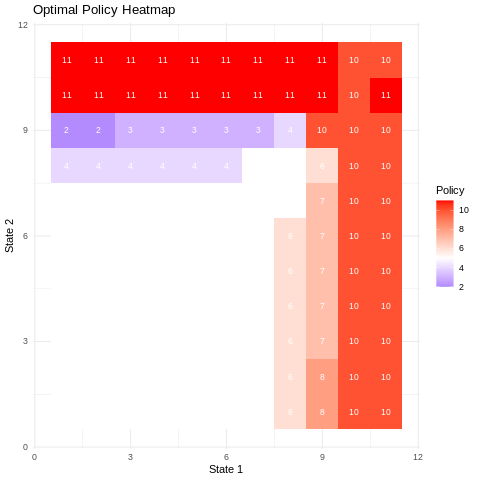

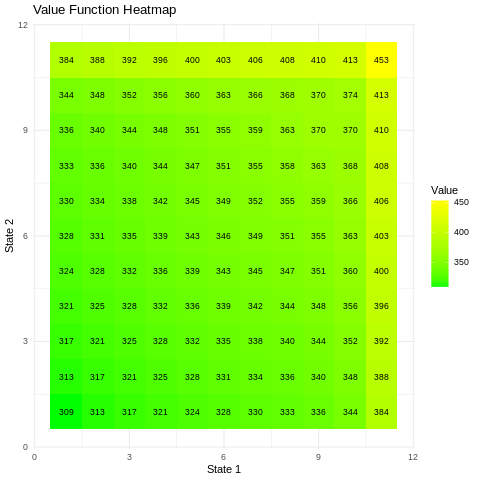

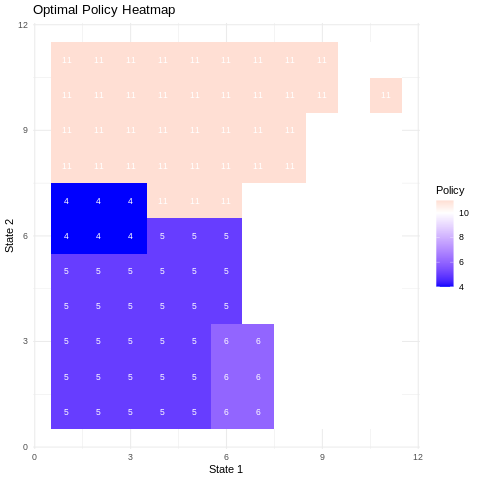

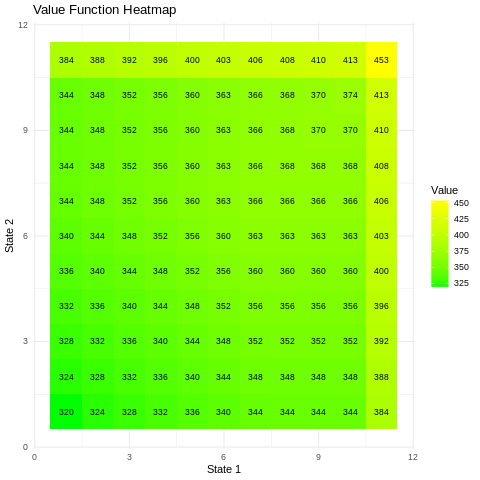

In [49]:
%%R
# 最適ポリシーのヒートマップ

for (h in 1:load_total_num) {
  policy_matrix <- matrix(op2_list[[h]], nrow = sta, ncol = sta, byrow = TRUE)
  policy_df <- melt(policy_matrix)  # reshape2 の melt 関数を使用
  names(policy_df) <- c("State1", "State2", "Policy")

  policy_plot <- ggplot(policy_df, aes(x = State1, y = State2, fill = Policy)) +
    geom_tile() +
    geom_text(aes(label = Policy), color = "white", size = 3) +  # 数値を追加
    scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = median(policy_df$Policy)) +
    theme_minimal() +
    labs(title = "Optimal Policy Heatmap", x = "State 1", y = "State 2", fill = "Policy")

    print(policy_plot)  # プロットを表示

  # 価値関数のヒートマップ
  value_matrix <- matrix(v2_list[[h]], nrow = sta, ncol = sta, byrow = TRUE)
  value_df <- melt(value_matrix)  # reshape2 の melt 関数を使用
  names(value_df) <- c("State1", "State2", "Value")

  value_plot <- ggplot(value_df, aes(x = State1, y = State2, fill = Value)) +
    geom_tile() +
    geom_text(aes(label = sprintf("%.0f", Value)), color = "black", size = 3) +  # 数値を追加、小数点以下2桁で表示
    scale_fill_gradient(low = "green", high = "yellow") +
    theme_minimal() +
    labs(title = "Value Function Heatmap", x = "State 1", y = "State 2", fill = "Value")
  print(value_plot)  # プロットを表示
}

In [ ]:
%%R
for (h in 1:load_total_num) {
  # 最適ポリシーのヒートマップの作成
  policy_matrix <- matrix(op2_list[h], nrow = sta, ncol = sta, byrow = TRUE)
  policy_df <- melt(policy_matrix)  # reshape2 の melt 関数を使用
  names(policy_df) <- c("State1", "State2", "Policy")

  # ggplot2 を使った可視化
  ggplot(policy_df, aes(x = State1, y = State2, fill = Policy)) +
    geom_tile() +
    geom_text(aes(label = Policy), color = "white", size = 3) +  # 数値も表示
    scale_fill_gradient2(low = "blue", high = "black", mid = "yellow", midpoint = median(policy_df$Policy)) +
    theme_minimal() +
    labs(title = "Optimal Policy Heatmap", x = "State 1", y = "State 2", fill = "Policy")
}

  'x' must be atomic




Error in sort.int(x, na.last = na.last, decreasing = decreasing, ...) : 
  'x' must be atomic


In [ ]:
"""
%%R


#ガンマ過程を離散化し推移確率行列を計算 #変更なし
TPM_gammaprocess = function(a,b,L,m,dt) {
    P = matrix(0,nrow=m+1,ncol=m+1)
    dx = L/m
    prob = function(i,dx,dt,a,b) {
        (1/dx)*integrate(pgamma,(i-1)*dx,i*dx,shape=a*dt,scale=b)$value
    }
    prob = Vectorize(prob,"i")
    q = prob(1:m,dx,dt,a,b)
    p = diff(c(0,q))
    for (i in 1:m) {
        P[i,i:m] = p[1:(m+1-i)]
        P[i,m+1] = 1-sum(P[i,1:m])
    }
    P[m+1,m+1] = 1
    P[P<0] = 0

    return(P)
}

#一次元の累積分布の行列の作成 #変更なし
scalar_F_make = function(P,n){

    for(i in c(1:n)){
        for(j in c(2:n)){
            P[i,j] = P[i,j] + P[i,j-1]
        }
    }
    return(P)
}
#コピュラを用いた 2次元の推移確率行列の任意の行ベクトルの作成
row_make = function(pr1,pr2,n){
    c_rp = matrix(0, nrow=n, ncol=n)

    for(i in c(1:n)){
        for(j in c(1:n)){
            #用いるコピュラに合わせて変更
            c_rp[i,j] = pCopula(c(pr2[i], pr1[j]), gumbelCopula(2))
        }
        dd = diff(c_rp[i,])
        for(k in c(2:n)){
            c_rp[i,k] = dd[(k-1)]
        }
    }

    for(j in c(1:n)){
        ds = diff(c_rp[,j])
        for(q in c(2:n)){
            c_rp[q,j] = ds[(q-1)]
        }
    }

    return(c_rp)
}

#コピュラを用いた推移確率行列の作成
make_Pcopula3 = function(P1,P2,n){
    P1F = scalar_F_make(P1,n)
    P2F = scalar_F_make(P2,n)

    P_cp = matrix(0, ncol=n*n, nrow = n*n)

    for(i in c(1:n)){
        for(j in c(1:n)){
row1 = row_make(P1F[i,],P2F[j,],n)

inx = (i-1)*n + j
P_cp[inx,] = row1
}
}
return(P_cp)
}

#劣化状態の階級数 (故障閾値以下)
status_d = 10
sta = status_d + 1 #故障の状態を追加 (+1)

#負荷配分の階級数
sharing_status = 9

#総負荷のリスト
load_total_list = c(1)#総負荷変動
#load_total_num=length(load_total_list)
load_total = 1

#ガンマ分布の尺度パラメータのと劣化状態の関係式
scale_re = function (x,n,load_total){
    #sh_para = c(0.79,0.98,1.31,1.76,2.34,3.05,3.90,4.87,5.97)
    load=load_total*(x/(n+1))
    sh_para=6.491*(load**2)+0.726
    return(sh_para)
}

#故障閾値
L = 25 #0911

#劣化状態の推移行列
i=1


create_transition_matrices <- function(sharing_status, status_d, L,load_total) {
    #各負荷配分率の下での推移行列
    P <- as.list(NULL)
    #それぞれの尺度パラメータ別の推移行列の作成
    for (i in 1:sharing_status) {
        Pn <- TPM_gammaprocess(25/36, scale_re(i, sharing_status,load_total), L, status_d, 1)
        P <- c(P, list(Pn))
    }
    return(P)
}

P=create_transition_matrices(sharing_status, status_d, L, load_total)

#割引係数
disc = 0.99

#費用の定義
P.Cost = c(1:sta)
R.Cost = c(1:sta)
c_pm = 40 #0911
c_cm = 80 #0911
c_setup = 0 #0911

d_wid = (L/status_d)*(1/2)
for(i in c(1:sta)){#変更なし
    if(i < sta){
        R.Cost[i] = c_pm
        #P.Cost[i] = round(40*3^(0.02*(d_wid*i)))
        P.Cost[i] = 0 #0911
    } else {
        R.Cost[i] = c_cm
        P.Cost[i] = 100 #故障時の稼働継続コスト#0911
    }
}

#二つのコストの一次元化
cost_function = function(R){
    n.1 = length(R[[1]])
    n.2 = length(R[[2]])
    r.n = c(1:(n.1*n.2))
    for(i in c(1:n.1)){
        for(j in c(1:n.2)){
            r.n[n.1*(i-1)+j] = R[[1]][i] + R[[2]][j]
        }
    }
    return(r.n)
}

PP.cost = cost_function(list(P.Cost,P.Cost))

#保全行動の推移行列
P.Rpl = cbind(1,matrix(0,sta,sta-1))
rownames(P.Rpl) = c(1:sta)
colnames(P.Rpl) = c(1:sta)
ze = numeric(sta)
RP.cost = cost_function(list(R.Cost,ze))
PR.cost = cost_function(list(ze,R.Cost))
RR.cost = cost_function(list(R.Cost,R.Cost))

#セットアップコストの追加
PR.cost = PR.cost + c_setup
RP.cost = RP.cost + c_setup
RR.cost = RR.cost + c_setup
p_label <- paste("Label", 1:(sta*sta), sep="")
#劣化状態の推移行列
p.Dgr = as.list(NULL)
for (i in c(1:(sharing_status))){
    pk <- make_Pcopula3(P[[i]],P[[sharing_status+1-i]],sta)
    colnames(pk) = p_label
    rownames(pk) = p_label
    p.Dgr <- c(p.Dgr, list(pk))
    #print(c(i,sharing_status+1-i))
}

#保全の推移行列についてもクロネッカー積をとる
RP = kronecker(P.Rpl,diag(sta))
PR = kronecker(diag(sta),P.Rpl)
RR = kronecker(P.Rpl,P.Rpl)

#mdptoolbox の準備
n.action <- sharing_status+3
A <- array(dim=c(sta^2, sta^2, n.action))
for(i in c(1:(sharing_status))){
    A[,,i] <- p.Dgr[[i]]
}
A[,,n.action-2] = PR #10
A[,,n.action-1] = RP #11
A[,,n.action] = RR #12
Cost = cbind(PP.cost,PP.cost,PP.cost,PP.cost,PP.cost,PP.cost,PP.cost,
PP.cost,PP.cost,PR.cost,RP.cost,RR.cost)
R = -Cost

#value-iteration 計算
result = mdp_value_iteration(A, R, disc)

#結果
op = result$policy
V1 = result$V
iter = result$iter

#optimal_policy を二次元にする
op.2 = matrix(0, nrow=sta, ncol=sta)
v.2 = matrix(0, nrow=sta, ncol=sta)
for(i in c(1:sta)){
    for(j in c(1:sta)){
        op.2[i,j] = op[(i-1)*sta+j]
        v.2[i,j] = -V1[(i-1)*sta+j]
    }
}

"""

'\n%%R\n\n\n#ガンマ過程を離散化し推移確率行列を計算 #変更なし\nTPM_gammaprocess = function(a,b,L,m,dt) {\n    P = matrix(0,nrow=m+1,ncol=m+1)\n    dx = L/m\n    prob = function(i,dx,dt,a,b) {\n        (1/dx)*integrate(pgamma,(i-1)*dx,i*dx,shape=a*dt,scale=b)$value\n    }\n    prob = Vectorize(prob,"i")\n    q = prob(1:m,dx,dt,a,b)\n    p = diff(c(0,q))\n    for (i in 1:m) {\n        P[i,i:m] = p[1:(m+1-i)]\n        P[i,m+1] = 1-sum(P[i,1:m])\n    }\n    P[m+1,m+1] = 1\n    P[P<0] = 0\n\n    return(P)\n}\n\n#一次元の累積分布の行列の作成 #変更なし\nscalar_F_make = function(P,n){\n\n    for(i in c(1:n)){\n        for(j in c(2:n)){\n            P[i,j] = P[i,j] + P[i,j-1]\n        }\n    }\n    return(P)\n}\n#コピュラを用いた 2次元の推移確率行列の任意の行ベクトルの作成\nrow_make = function(pr1,pr2,n){\n    c_rp = matrix(0, nrow=n, ncol=n)\n\n    for(i in c(1:n)){\n        for(j in c(1:n)){\n            #用いるコピュラに合わせて変更\n            c_rp[i,j] = pCopula(c(pr2[i], pr1[j]), gumbelCopula(2))\n        }\n        dd = diff(c_rp[i,])\n        for(k in c(2:n)){\n      

In [46]:
"""
%%R

scale_re <- function(x, n, load_total) {
    load = load_total * (x / (n + 1))
    sh_para = 6.491 * (load ^ 2) + 0.726
    return(sh_para)
}

make_Pcopula3 <- function(P1, P2, n) {
    P1F = scalar_F_make(P1, n)
    P2F = scalar_F_make(P2, n)
    P_cp = matrix(0, ncol = n * n, nrow = n * n)
    for (i in 1:n) {
        for (j in 1:n) {
            row1 = row_make(P1F[i, ], P2F[j, ], n)
            inx = (i - 1) * n + j
            P_cp[inx, ] = row1
        }
    }
    return(P_cp)
}

# 一次元の累積分布行列の作成
scalar_F_make <- function(P, n) {
    for (i in 1:n) {
        for (j in 2:n) {
            P[i, j] = P[i, j] + P[i, j - 1]
        }
    }
    return(P)
}

row_make <- function(pr1, pr2, n) {
    c_rp = matrix(0, nrow = n, ncol = n)

    for (i in 1:n) {
        for (j in 1:n) {
            # 用いるコピュラに合わせて変更
            c_rp[i, j] = pCopula(c(pr2[i], pr1[j]), gumbelCopula(2))
        }
        dd = diff(c_rp[i,])
        for (k in 2:n) {
            c_rp[i, k] = dd[(k - 1)]
        }
    }

    for (j in 1:n) {
        ds = diff(c_rp[, j])
        for (q in 2:n) {
            c_rp[q, j] = ds[(q - 1)]
        }
    }

    return(c_rp)
}
TPM_gammaprocess <- function(a, b, L, m, dt) {
    P = matrix(0, nrow = m + 1, ncol = m + 1)
    dx = L / m
    prob = Vectorize(function(i) {
        (1 / dx) * integrate(pgamma, (i - 1) * dx, i * dx, shape = a * dt, scale = b)$value
    }, "i")
    q = prob(1:m)
    p = diff(c(0, q))
    for (i in 1:m) {
        P[i, i:m] = p[1:(m + 1 - i)]
        P[i, m + 1] = 1 - sum(P[i, 1:m])
    }
    P[m + 1, m + 1] = 1
    P[P < 0] = 0
    return(P)
}

create_transition_matrices <- function(sharing_status, status_d, L, load_total, sta) {
    P <- as.list(NULL)
    for (i in 1:sharing_status) {
        P1 <- TPM_gammaprocess(25/36, scale_re(i, sharing_status, load_total), L, status_d, 1)
        P2 <- TPM_gammaprocess(25/36, scale_re(sharing_status + 1 - i, sharing_status, load_total), L, status_d, 1)
        pk <- make_Pcopula3(P1, P2, sta)
        colnames(pk) <- paste("Label", 1:(sta * sta), sep = "")
        rownames(pk) <- paste("Label", 1:(sta * sta), sep = "")
        P <- c(P, list(pk))
    }
    return(P)
}

sharing_status=2
status_d=3
L=15
sta=4
load_total_list <- list(1, 2)
n.action <- sharing_status + 3

all_As <- lapply(load_total_list, function(load_total) {
  # p.Dgr を生成
  p.Dgr <- create_transition_matrices(sharing_status, status_d, L, load_total, sta)

  # A 行列を設定

  A <- array(dim = c(sta^2, sta^2, n.action))
  for (i in 1:sharing_status) {
    A[, , i] <- p.Dgr[[i]]
  }

  # PR, RP, RR 行列の追加
  P.Rpl <- cbind(1, matrix(0, sta, sta - 1))
  rownames(P.Rpl) <- colnames(P.Rpl) <- 1:sta
  PR <- kronecker(diag(sta), P.Rpl)
  RP <- kronecker(P.Rpl, diag(sta))
  RR <- kronecker(P.Rpl, P.Rpl)

  A[, , n.action - 2] <- PR
  A[, , n.action - 1] <- RP
  A[, , n.action] <- RR

  return(A)
})


#print(create_transition_matrices(2,3,15,1,4))
#print(create_transition_matrices(2,3,15,2,4))


A2 <- abind::abind(all_As, along = 1)
print("A2")
# 結果の確認
#print(A2)
load_total_num=length(load_total_list)
A2_normalized <- A2 / load_total_num
print("A2_normalized")
print(A2_normalized)
print(dim(A2_normalized))

# 3次元配列の各行を繰り返し処理する
rows <- dim(A2_normalized)[1]
cols <- dim(A2_normalized)[2]
depth <- dim(A2_normalized)[3]

# 拡張行列を初期化
extended_matrix <- array(NA, dim = c(rows, cols * load_total_num, depth))

# 各行について繰り返しを行い、新しい行列に追加
for (i in 1:rows) {
    # 現在の行全体（すべての列と深さ）を取得
    current_row <- A2_normalized[i, , ]
    # 行全体を load_total_num 回繰り返して新しい行ベクトルを作成
    for (j in 1:depth) {
        extended_matrix[i, , j] <- rep(current_row[, j], times = load_total_num)
    }
}

print("A3")
print(extended_matrix)
"""

[1] "A2"
[1] "A2_normalized"
, , 1

           [,1]      [,2]       [,3]         [,4]       [,5]       [,6]
 [1,] 0.2853588 0.1106728 0.00531178 0.0002624703 0.01300482 0.05270089
 [2,] 0.0000000 0.2853588 0.11067279 0.0055742499 0.00000000 0.01300482
 [3,] 0.0000000 0.0000000 0.28535882 0.1162470431 0.00000000 0.00000000
 [4,] 0.0000000 0.0000000 0.00000000 0.4016058646 0.00000000 0.00000000
 [5,] 0.0000000 0.0000000 0.00000000 0.0000000000 0.28535882 0.11067279
 [6,] 0.0000000 0.0000000 0.00000000 0.0000000000 0.00000000 0.28535882
 [7,] 0.0000000 0.0000000 0.00000000 0.0000000000 0.00000000 0.00000000
 [8,] 0.0000000 0.0000000 0.00000000 0.0000000000 0.00000000 0.00000000
 [9,] 0.0000000 0.0000000 0.00000000 0.0000000000 0.00000000 0.00000000
[10,] 0.0000000 0.0000000 0.00000000 0.0000000000 0.00000000 0.00000000
[11,] 0.0000000 0.0000000 0.00000000 0.0000000000 0.00000000 0.00000000
[12,] 0.0000000 0.0000000 0.00000000 0.0000000000 0.00000000 0.00000000
[13,] 0.0000000 0.0000000 0.